# **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np

import os
import sys
import timeit
from tqdm import tqdm

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
import tensorflow as tf 
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, BatchNormalization
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

2026-02-22 08:08:29.719210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771747710.085247      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771747710.180366      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771747711.175470      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771747711.175515      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771747711.175517      24 computation_placer.cc:177] computation placer alr

In [2]:
# Paths for data.
Ravdess = "/kaggle/input/datasets/uwrfkaggler/ravdess-emotional-speech-audio"
Tess = "/kaggle/input/datasets/ejlok1/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data"

# **Data Preprocessing**

## **1. Ravdess Dataframe**

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    if not dir.startswith("Actor_"):
        continue   # skip unwanted folder
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + "/" + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + "/" + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.head()

,Emotions,Path
0,surprise,/kaggle/input/datasets/uwrfkaggler/ravdess-emo...
1,neutral,/kaggle/input/datasets/uwrfkaggler/ravdess-emo...
2,disgust,/kaggle/input/datasets/uwrfkaggler/ravdess-emo...
3,disgust,/kaggle/input/datasets/uwrfkaggler/ravdess-emo...
4,neutral,/kaggle/input/datasets/uwrfkaggler/ravdess-emo...


## **2. TESS Dataframe**

In [4]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + "/" + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + "/" + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
tess_df = pd.concat([emotion_df, path_df], axis=1)
tess_df.head()

,Emotions,Path
0,fear,/kaggle/input/datasets/ejlok1/toronto-emotiona...
1,fear,/kaggle/input/datasets/ejlok1/toronto-emotiona...
2,fear,/kaggle/input/datasets/ejlok1/toronto-emotiona...
3,fear,/kaggle/input/datasets/ejlok1/toronto-emotiona...
4,fear,/kaggle/input/datasets/ejlok1/toronto-emotiona...


## **Concatination of dataframes**

In [5]:
# creating Dataframe using the 2 dataframes we created so far.
emotion_path = pd.concat([ravdess_df, tess_df], axis=0)
emotion_path.to_csv("/kaggle/working/emotion_path.csv",index=False)
emotion_path.head()

,Emotions,Path
0,surprise,/kaggle/input/datasets/uwrfkaggler/ravdess-emo...
1,neutral,/kaggle/input/datasets/uwrfkaggler/ravdess-emo...
2,disgust,/kaggle/input/datasets/uwrfkaggler/ravdess-emo...
3,disgust,/kaggle/input/datasets/uwrfkaggler/ravdess-emo...
4,neutral,/kaggle/input/datasets/uwrfkaggler/ravdess-emo...


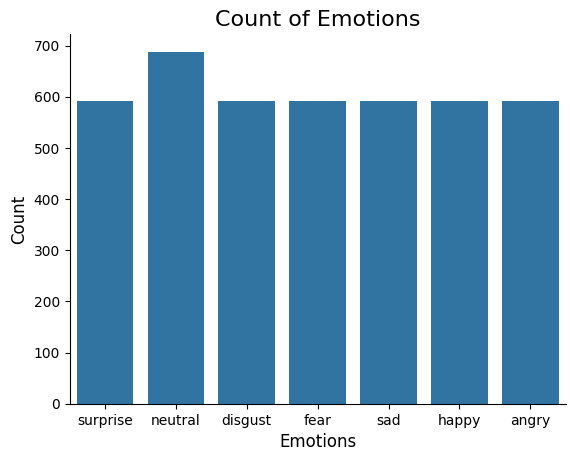

In [6]:
plt.title('Count of Emotions', size=16)
sns.countplot(data=emotion_path, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [7]:
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveform ({emotion})', fontsize=15)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()


def create_mel_spectrogram(data, sr, emotion):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    plt.figure(figsize=(12, 3))
    plt.title(f'Mel Spectrogram ({emotion})')

    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

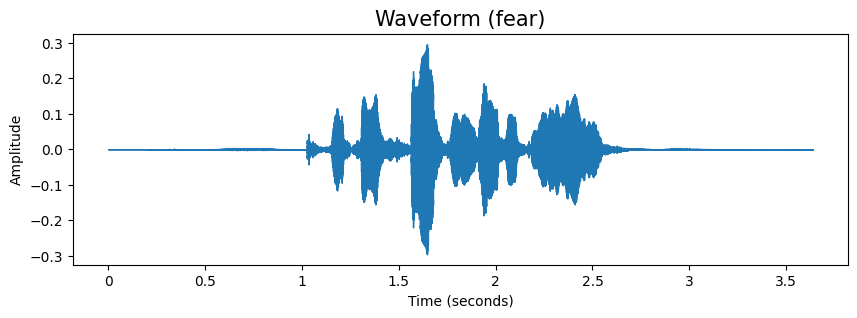

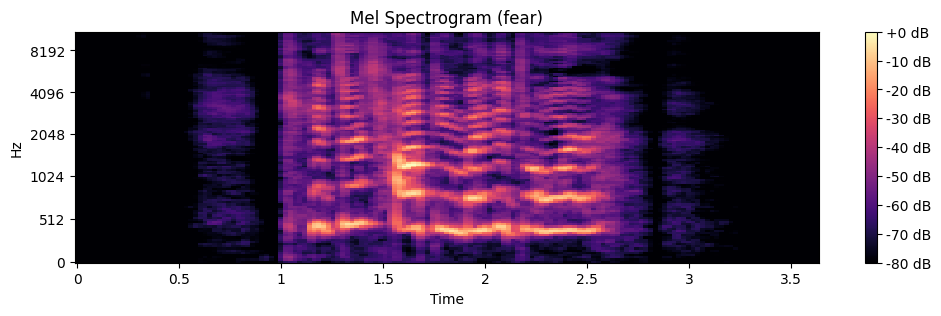

In [8]:
emotion='fear'
path = np.array(emotion_path.Path[emotion_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
Audio(path)

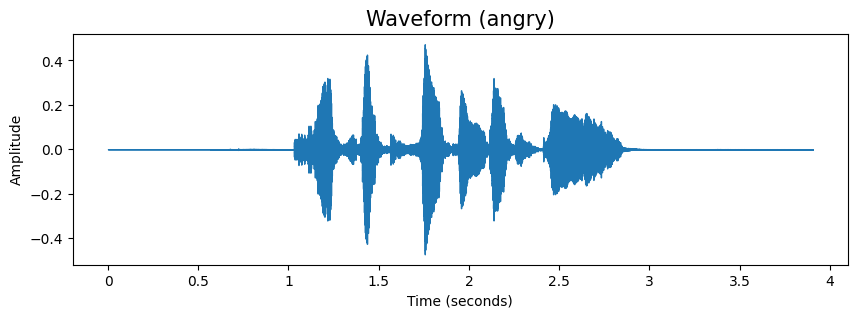

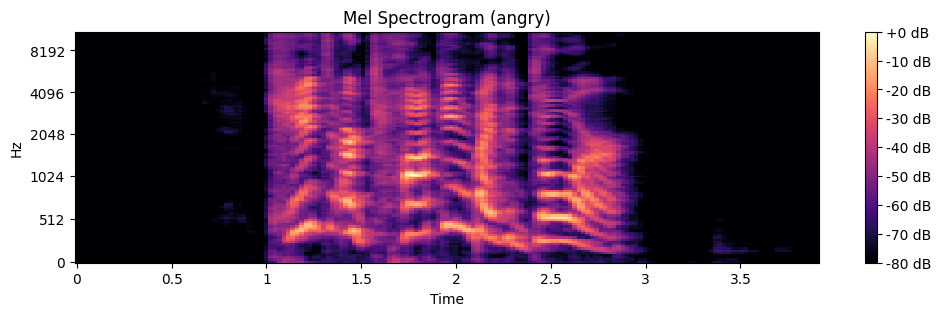

In [9]:
emotion='angry'
path = np.array(emotion_path.Path[emotion_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
Audio(path)

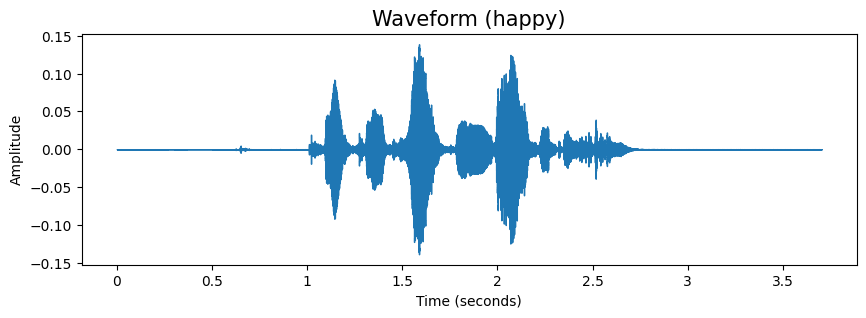

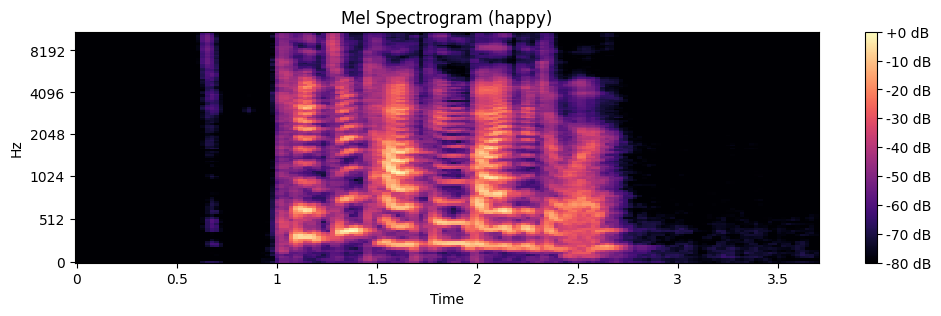

In [10]:
emotion='happy'
path = np.array(emotion_path.Path[emotion_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
Audio(path)

# **Data Augmentation**

In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [12]:
# Test on example audio
path = np.array(emotion_path.Path)[1]
data, sample_rate = librosa.load(path)

**1. Simple Audio**

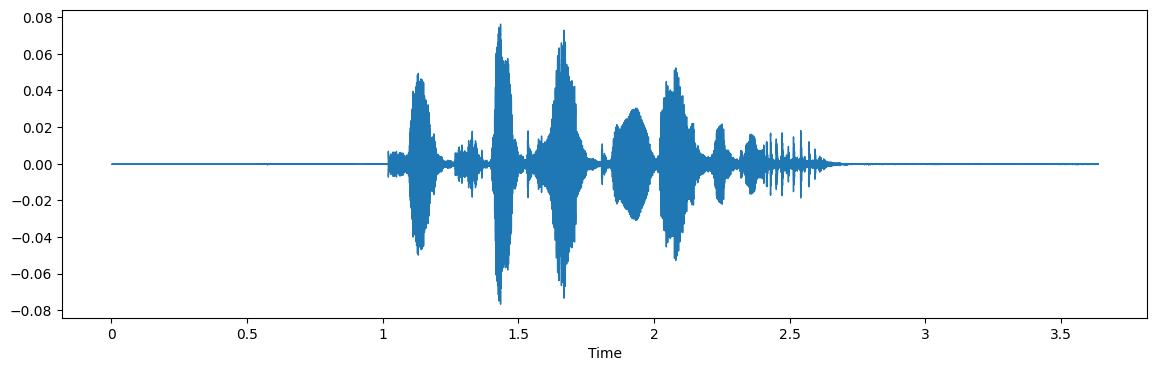

In [13]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

**2. Noise Injection**

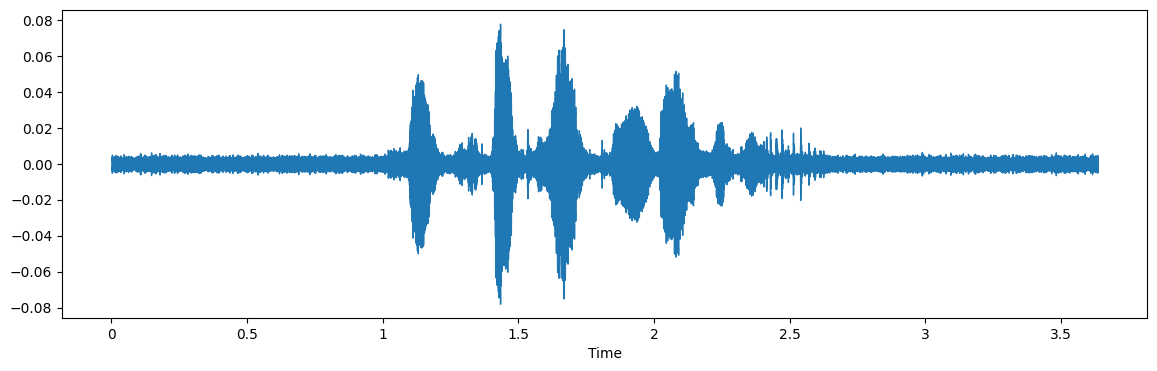

In [14]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

**3. Stretching**

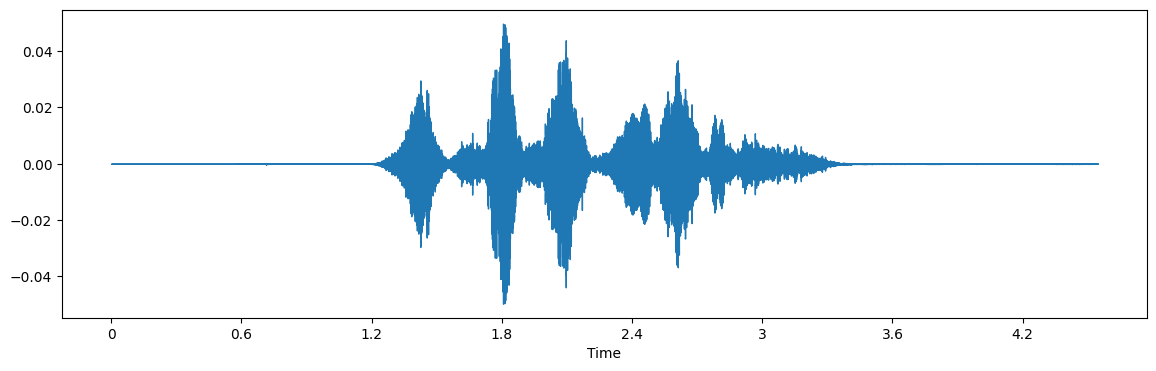

In [15]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

**4. Shifting**

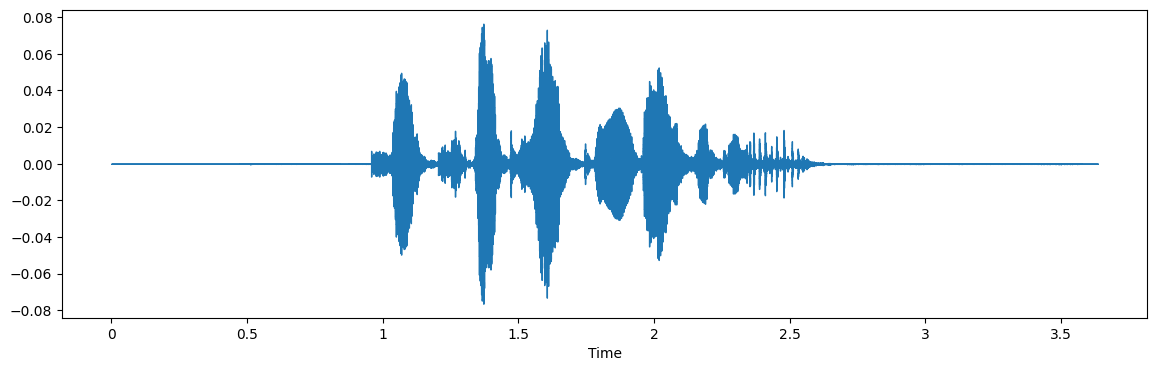

In [16]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

**5. Pitch**

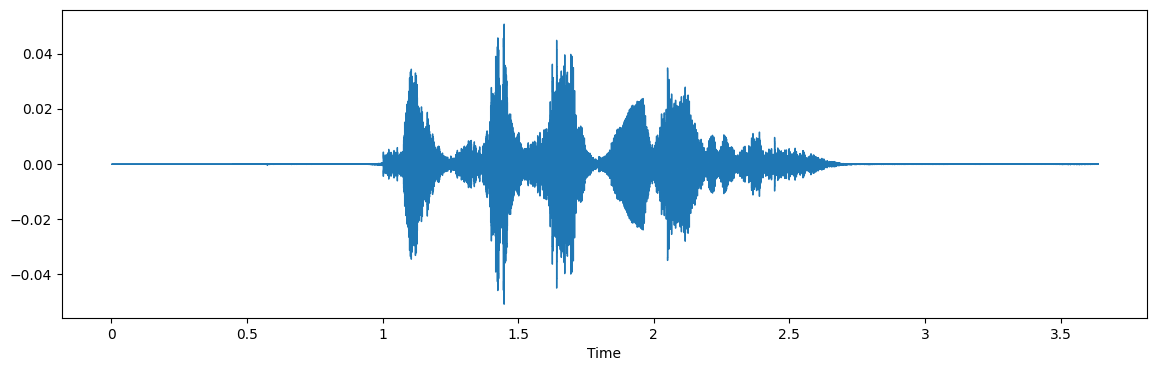

In [17]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# **Feature Extraction**

In this project, I am not going deep in feature selection process to check which features are good for our dataset rather, I am only extracting 5 features:

- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [18]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [19]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [20]:
start = timeit.default_timer()
X, Y = [], []
for path, emotion, index in tqdm (zip(emotion_path.Path, emotion_path.Emotions, range(emotion_path.Path.shape[0]))):
    features=get_features(path)
    if index % 500 == 0:
        print(f'{index} audio has been processed')
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

2it [00:00,  6.08it/s]

0 audio has been processed


502it [01:22,  6.16it/s]

500 audio has been processed


1002it [02:45,  6.03it/s]

1000 audio has been processed


1502it [04:04,  8.88it/s]

1500 audio has been processed


2002it [04:55,  9.69it/s]

2000 audio has been processed


2502it [05:56,  8.18it/s]

2500 audio has been processed


3002it [07:02,  7.65it/s]

3000 audio has been processed


3502it [08:01,  8.64it/s]

3500 audio has been processed


4002it [09:01,  7.88it/s]

4000 audio has been processed


4240it [09:29,  7.45it/s]

Done
Time:  569.035452308


In [21]:
len(X), len(Y), emotion_path.Path.shape

(12720, 12720, (4240,))

In [22]:
features_df = pd.DataFrame(X)
features_df['labels'] = Y
features_df.to_csv('/kaggle/working/features.csv', index=False)
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.237382,0.682273,0.670519,0.614793,0.579039,0.566803,0.637206,0.667451,0.663883,0.669903,...,0.000234,0.000235,0.000138,0.000128,0.000299,0.000360,0.000275,0.000173,2.896729e-05,surprise
1,0.293525,0.688410,0.698288,0.685484,0.674091,0.686777,0.704746,0.693767,0.675139,0.683099,...,0.000361,0.000355,0.000249,0.000242,0.000416,0.000476,0.000395,0.000289,1.369059e-04,surprise
2,0.185670,0.701610,0.669992,0.646515,0.569479,0.522188,0.620175,0.694170,0.706142,0.679076,...,0.000047,0.000049,0.000054,0.000048,0.000024,0.000053,0.000074,0.000031,2.444070e-06,surprise
3,0.256113,0.621621,0.580278,0.598515,0.628296,0.598014,0.597272,0.650352,0.698635,0.681863,...,0.000018,0.000016,0.000013,0.000012,0.000007,0.000008,0.000008,0.000005,5.802854e-07,neutral
4,0.315565,0.680367,0.689055,0.736162,0.746843,0.718441,0.655271,0.695887,0.728825,0.712220,...,0.000182,0.000171,0.000163,0.000168,0.000162,0.000152,0.000145,0.000151,1.493706e-04,neutral


# **Data Preparation**

In [23]:
X = features_df.drop(columns='labels').values
Y = features_df['labels'].values

In [24]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10176, 162), (10176, 7), (2544, 162), (2544, 7))

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
# making our data compatible to model.
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10176, 162, 1), (10176, 7), (2544, 162, 1), (2544, 7))

# **CNN Model**

In [28]:
model = Sequential()

# Block 1
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same',
                 activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Block 2
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

# Block 3
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Block 4
model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

# Block 5
model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.2))

# Dense Head
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1771748342.715673      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771748342.721808      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 512)       │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 162, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 512)        │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 81, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 256)        │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 11, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,59

 Total params: 2,671,239 (10.19 MB)

 Trainable params: 2,666,887 (10.17 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [29]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,          # reduce LR by half
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_emotion_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [30]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, lr_reduction, model_checkpoint]
)

Epoch 1/100


I0000 00:00:1771748350.003021      80 service.cc:152] XLA service 0x7a9bd810baf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771748350.003063      80 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771748350.003067      80 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771748350.897916      80 cuda_dnn.cc:529] Loaded cuDNN version 91002


  5/159 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.1635 - loss: 2.4939

I0000 00:00:1771748360.172316      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4713 - loss: 1.5651
Epoch 1: val_accuracy improved from -inf to 0.18829, saving model to /kaggle/working/best_emotion_model.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.4733 - loss: 1.5587 - val_accuracy: 0.1883 - val_loss: 1.9716 - learning_rate: 0.0010
Epoch 2/100
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7006 - loss: 0.8456
Epoch 2: val_accuracy improved from 0.18829 to 0.26415, saving model to /kaggle/working/best_emotion_model.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7008 - loss: 0.8448 - val_accuracy: 0.2642 - val_loss: 2.3792 - learning_rate: 0.0010
Epoch 3/100
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7401 - loss: 0.7005
Epoch 3: val_accuracy improved from 0.26415 to 0.36203, saving model to /kaggle/working/best_emotion_model.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7402 - loss: 0.7004 - val_accuracy: 0.3620 - val_loss: 1.9951 - learnin

80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9144 - loss: 0.3066
Accuracy of our model on test data :  91.58805012702942 %


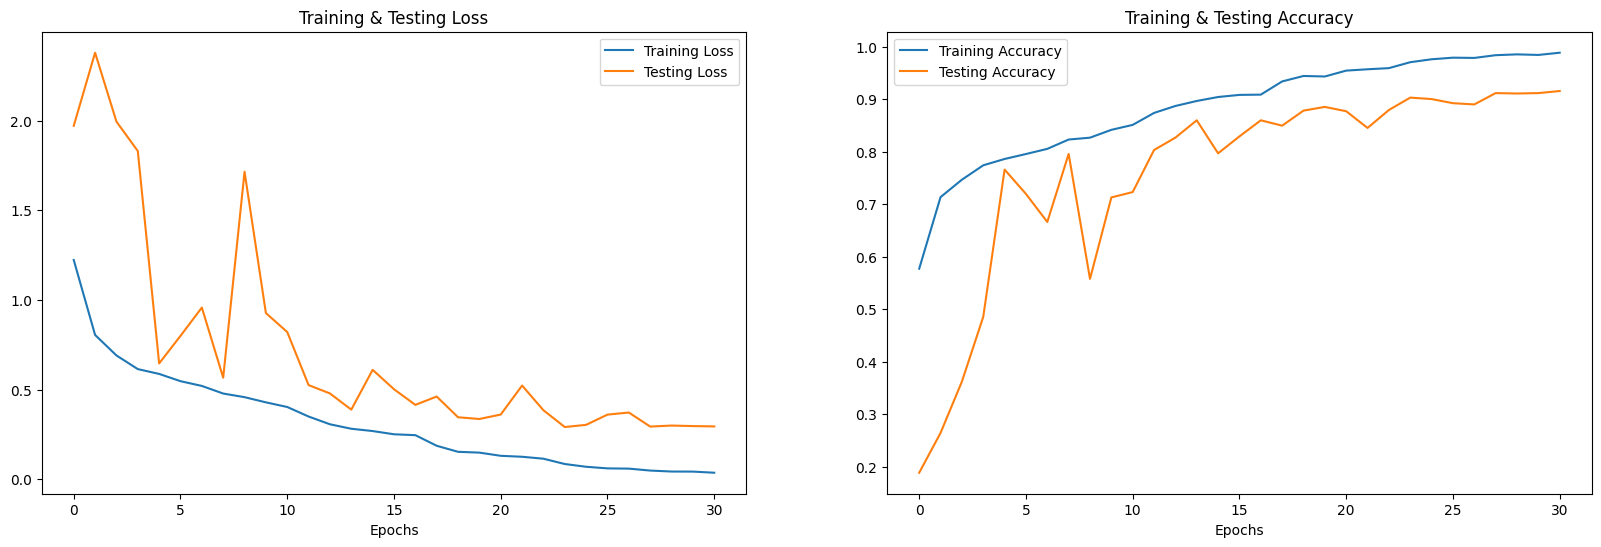

In [31]:
model = load_model('/kaggle/working/best_emotion_model.keras')
print("Accuracy of our model on test data : " , model.evaluate(X_test, y_test)[1]*100 , "%")

epochs = range(len(history.history['loss']))
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [32]:
# predicting on test data.
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [33]:
df = pd.DataFrame(columns=['Actual Labels', 'Predicted Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Actual Labels,Predicted Labels
0,disgust,disgust
1,neutral,neutral
2,sad,neutral
3,disgust,disgust
4,happy,happy
5,angry,surprise
6,disgust,sad
7,disgust,disgust
8,neutral,neutral
9,surprise,surprise


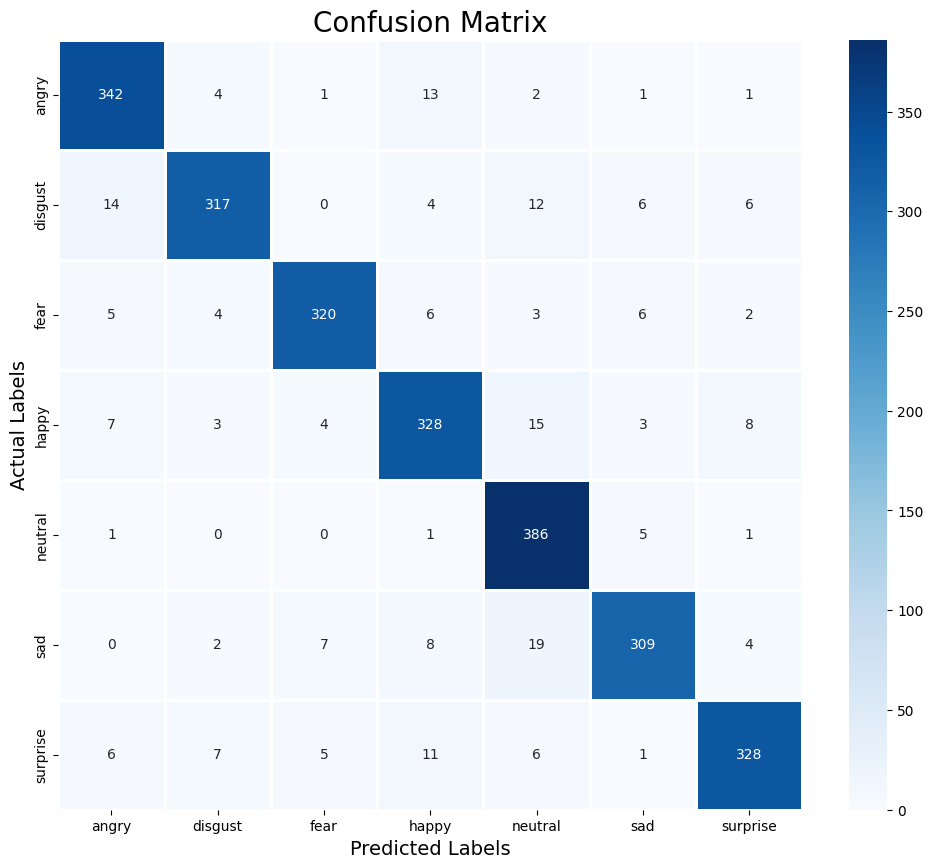

In [34]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.91      0.94      0.93       364
     disgust       0.94      0.88      0.91       359
        fear       0.95      0.92      0.94       346
       happy       0.88      0.89      0.89       368
     neutral       0.87      0.98      0.92       394
         sad       0.93      0.89      0.91       349
    surprise       0.94      0.90      0.92       364

    accuracy                           0.92      2544
   macro avg       0.92      0.91      0.92      2544
weighted avg       0.92      0.92      0.92      2544



# **Saving files and methods**

In [36]:
class Extractor:
    def extract_features(self, data, sr):
        result = np.array([])
    
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
        result = np.hstack((result, zcr))
    
        stft = np.abs(librosa.stft(data))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
        result = np.hstack((result, chroma))
    
        mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr).T, axis=0)
        result = np.hstack((result, mfcc))
    
        rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
        result = np.hstack((result, rms))
    
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
        result = np.hstack((result, mel))
    
        return result

    def get_predict_feat(self, path):
        data, sr = librosa.load(path, sr=22050, duration=2.5, offset=0.6)
        features = self.extract_features(data, sr) # Since same as training
        return features

In [37]:
import joblib

emotion_preprocess = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'extractor': Extractor(),
}

joblib.dump(emotion_preprocess, '/kaggle/working/emotion_preprocessing.joblib')

['/kaggle/working/emotion_preprocessing.joblib']

# **Testing on custom file**

In [38]:
emotion_preprocess = joblib.load('/kaggle/working/emotion_preprocessing.joblib')

In [39]:
def get_predictions(path, emotion_preprocess):
    final_model = emotion_preprocess['model']
    scaler = emotion_preprocess['scaler']
    encoder = emotion_preprocess['encoder']
    extractor = emotion_preprocess['extractor']

    # extractor is already an object of class Extractor
    features = extractor.get_predict_feat(path)
    features = features.reshape(1, -1)     # match training shape
    features = scaler.transform(features)
    features = np.expand_dims(features, 2) # For Conv1D input
    predictions = final_model.predict(features)
    y_pred = encoder.inverse_transform(predictions)
    
    return y_pred[0][0]

In [40]:
!pip freeze > /kaggle/working/requirements.txt

In [41]:
get_predictions('/kaggle/input/datasets/uwrfkaggler/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav', emotion_preprocess)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


'neutral'

In [42]:
get_predictions('/kaggle/input/datasets/ejlok1/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_back_ps.wav', emotion_preprocess)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


'surprise'

This project was developed with valuable insights and ideas gathered from several excellent Kaggle notebooks and GitHub repos. Their approaches to feature engineering, preprocessing, and model design significantly influenced this work.

Special thanks to:

- <a href="https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition" target="_blank">Speech Emotion Recognition</a> by Shivam Burnwal  
- <a href="https://www.kaggle.com/code/mostafaabdlhamed/speech-emotion-recognition-97-25-accuracy/" target="_blank">Speech Emotion Recognition — 97.25% Accuracy</a> by Mostafa Abdel hamed
- <a href="https://github.com/marcogdepinto/emotion-classification-from-audio-files/" target="_blank">Emotion Classification from audio files</a> by Marco Giuseppe de Pinto

These notebooks provided helpful ideas on:

✔ audio feature extraction  
✔ preprocessing pipelines  
✔ model architecture strategies  
✔ performance optimization techniques  

If you found this project useful, please consider **checking out and upvoting their notebooks** as well. They are excellent resources for anyone exploring speech emotion recognition.